In [1]:
# Goal: Perform synthetic photometry on the flux-calibrated spectra
import sys
import warnings
warnings.filterwarnings("ignore", module="dynesty.sampling")
import numba
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
import astropy.units as u
import astropy.table as table
#from synphot import SourceSpectrum, units, SpectralElement, Observation
#from synphot.models import Empirical1D
#import pyphot
#import pysynphot
import speclite
from pyphot import unit
import seaborn
import tqdm
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.specds as specds
import snelib19odp.dataset as dataset

In [2]:
sds = specds.load_dataset('SN2019odp')
ds = dataset.load_dataset('SN2019odp_phot')

In [3]:
obj = 'keck_early'
if obj == 'keck_early':
    spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
spec = spec[~np.isnan(spec['flux'])]

#sp = SourceSpectrum(
#    Empirical1D, points=spec['restwave'], lookup_table=spec['flux'] * units.FLAM, keep_neg=True)
#sp.plot(flux_unit=units.FLAM)


In [4]:
#bp = SpectralElement.from_file('../const/filters/SLOAN_SDSS.r.dat')
#obs = Observation(sp, bp)

In [5]:
#obs.integrate()

In [6]:
#spec['flux']

In [7]:
#wavelength = np.array(spec['obswave'], copy=True)# * unit['AA']
#flux = np.array(spec['flux'], copy=True)# * unit['erg/s/cm**2/AA']
#lib = pyphot.get_library()
#f = lib['SDSS_g']
#f = lib['HST_WFC3_F110W']
#-2.5 * np.log10(f.get_flux(wavelength, flux)) - f.AB_zero_mag


In [8]:
import speclite.filters
speclite.filters.load_filters('sdss2010-*').names

['sdss2010-u', 'sdss2010-g', 'sdss2010-r', 'sdss2010-i', 'sdss2010-z']

In [9]:
wlen = spec['obswave'] * u.Angstrom
flux = spec['flux'] * u.erg / (u.cm**2 * u.s * u.Angstrom)
filters = speclite.filters.load_filters('sdss2010-g', 'sdss2010-r', 'sdss2010-i')

In [10]:
mags = filters.get_ab_magnitudes(flux, wlen)
mags

<Table length=1>
   sdss2010-g       sdss2010-r         sdss2010-i   
    float64          float64            float64     
--------------- ------------------ -----------------
19.347600507762 18.432553658101202 18.51097619806677

In [36]:
def load_ztf_filter(band):
    x = table.Table.read('../const/filters/Palomar_ZTF.%s.dat' % band, format='ascii')
    wave = x['col1']
    response = x['col2']
    wave_grid = np.arange(wave.min(), wave.max(), 1)
    response_gridded = np.interp(wave_grid, wave, response)
    response_gridded[0] = 0
    response_gridded[-1] = 0
    return speclite.filters.FilterResponse(wave_grid*u.Angstrom, response_gridded, meta={'group_name': 'Palomar_ZTF', 'band_name': band})

58861.85248678241     sdss2010-g    
------------------
19.015013024139968
58872.22917824074    sdss2010-g  
---------------
19.347600507762
58861.85248678241     sdss2010-r    
------------------
18.323856810117125
58872.22917824074     sdss2010-r    
------------------
18.432553658101202
58861.85248678241     sdss2010-i    
------------------
18.259058674136764
58872.22917824074     sdss2010-i   
-----------------
18.51097619806677


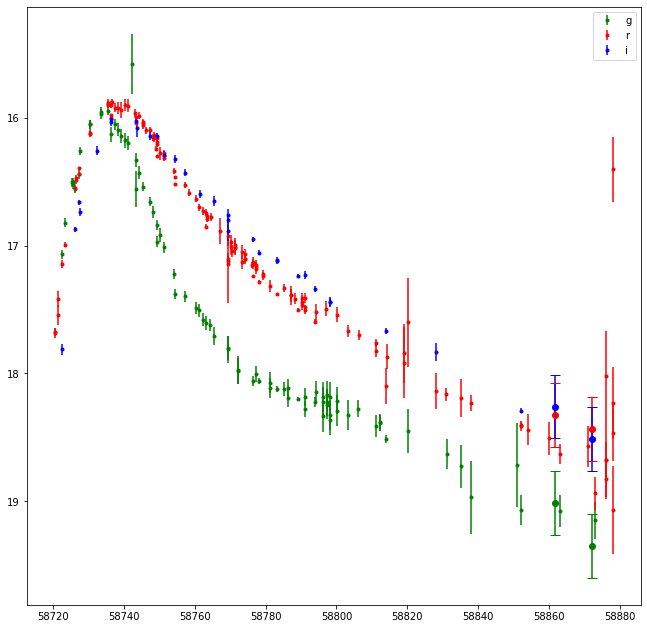

In [48]:
plt.figure(figsize=(11,11))
    
for band, color in [('g', 'green'), ('r', 'red'), ('i', 'blue')]:
    combined = ds.get_corrected_dataset(band, extinct_correct=True)
    idx = np.logical_and(~combined['upper_limit'], combined['mjd'] > 58720)
    idx = np.logical_and(idx, combined['mjd'] < 58880)
    plt.errorbar(combined['mjd'][idx], combined['mag'][idx], yerr=combined['mag_err'][idx], marker='.', label=band, ls='', color=color)
    for name in ['ZTF19abqwtfu_20200113_NOT_v1', 'ZTF19abqwtfu_20200124_Keck1_v1']:
        spec = sds[name]
        spec_mjd = spec.meta['obs_mjd']
        wlen = np.array(spec['obswave'], copy=True) * u.Angstrom
        flux = np.array(spec['flux'], copy=True) * u.erg / (u.cm**2 * u.s * u.Angstrom)
        idx = ~np.isnan(flux)
        wlen[np.arange(len(wlen))[idx][0]] = 2999 * u.Angstrom
        flux[np.arange(len(wlen))[idx][0]] =  0.0 * u.erg / (u.cm**2 * u.s * u.Angstrom)
        wlen[np.arange(len(wlen))[idx][-1]] = 11000 * u.Angstrom
        flux[np.arange(len(wlen))[idx][-1]] =  0.0 * u.erg / (u.cm**2 * u.s * u.Angstrom)
        #if wlen.min() > 3600 * u.Angstrom and band == 'g':
            #continue
        #    wlen[0] = 2000.0 * u.Angstrom
        #    flux[0] = 0.0 * u.erg / (u.cm**2 * u.s * u.Angstrom)
        #print(wlen)
        filters = speclite.filters.load_filters('sdss2010-%s' % band)
        #print(wlen)
        #filters = load_ztf_filter(band)
        #mag = filters.get_ab_magnitude(flux[idx], wlen[idx])
        mags = filters.get_ab_magnitudes(flux[idx], wlen[idx])
        
        mag = mags['sdss2010-%s' % band]
        print(spec_mjd, mag)
        plt.errorbar(spec_mjd, mag, yerr=0.25, marker='o', capsize=5, color=color)
plt.gca().invert_yaxis()
plt.legend()
plt.savefig('2022-03-24-synphot-early-filter_sloan.png')

In [12]:
sds.names

['ZTF19abqwtfu_20190821_P60_v1',
 'ZTF19abqwtfu_20190823_NTT_v1',
 'ZTF19abqwtfu_20190823_P60_v1',
 'ZTF19abqwtfu_20190824_P60_v1',
 'ZTF19abqwtfu_20190827_P200_v1',
 'ZTF19abqwtfu_20190827_P60_v1',
 'ZTF19abqwtfu_20190830_NOT_v1',
 'ZTF19abqwtfu_20190831_P60_v1',
 'ZTF19abqwtfu_20190910_P60_v1',
 'ZTF19abqwtfu_20190917_P60_v1',
 'ZTF19abqwtfu_20190922_P60_v1',
 'ZTF19abqwtfu_20190927_P60_v1',
 'ZTF19abqwtfu_20191003_NOT_v1',
 'ZTF19abqwtfu_20191006_P60_v1',
 'ZTF19abqwtfu_20191013_P60_v2',
 'ZTF19abqwtfu_20191019_P60_v1',
 'ZTF19abqwtfu_20191021_NOT_v1',
 'ZTF19abqwtfu_20191026_P60_v1',
 'ZTF19abqwtfu_20191103_P60_v1',
 'ZTF19abqwtfu_20191110_P60_v1',
 'ZTF19abqwtfu_20191122_NOT_v2',
 'ZTF19abqwtfu_20191123_P60_v1',
 'ZTF19abqwtfu_20191218_P60_v1',
 'ZTF19abqwtfu_20191221_P60_v1',
 'ZTF19abqwtfu_20200103_P60_v1',
 'ZTF19abqwtfu_20200113_NOT_v1',
 'ZTF19abqwtfu_20200124_Keck1_v1',
 'ZTF19abqwtfu_20200821_Keck1_v1']

59082.499085648145     sdss2010-g    
------------------
21.913434315137202
59082.499085648145     sdss2010-r    
------------------
21.368583539575383
59082.499085648145     sdss2010-i    
------------------
21.762814191652534


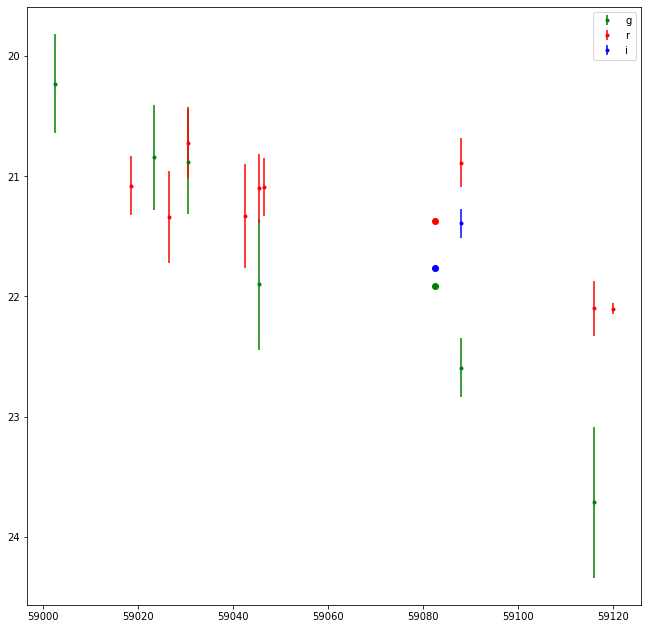

In [49]:
plt.figure(figsize=(11,11))
    
for band, color in [('g', 'green'), ('r', 'red'), ('i', 'blue')]:
    combined = ds.get_corrected_dataset(band, extinct_correct=True)
    idx = np.logical_and(~combined['upper_limit'], combined['mjd'] > 58900)
    #idx = np.logical_and(idx, combined['mjd'] < 58880)
    plt.errorbar(combined['mjd'][idx], combined['mag'][idx], yerr=combined['mag_err'][idx], marker='.', label=band, ls='', color=color)
    for name in ['ZTF19abqwtfu_20200821_Keck1_v1']:
        spec = sds[name]
        spec_mjd = spec.meta['obs_mjd']
        wlen = np.array(spec['obswave'], copy=True) * u.Angstrom
        flux = np.array(spec['flux'], copy=True) * u.erg / (u.cm**2 * u.s * u.Angstrom)
        idx = ~np.isnan(flux)
        wlen[np.arange(len(wlen))[idx][0]] = 2999 * u.Angstrom
        flux[np.arange(len(wlen))[idx][0]] =  0.0 * u.erg / (u.cm**2 * u.s * u.Angstrom)
        wlen[np.arange(len(wlen))[idx][-1]] = 11000 * u.Angstrom
        flux[np.arange(len(wlen))[idx][-1]] =  0.0 * u.erg / (u.cm**2 * u.s * u.Angstrom)
        if wlen.min() > 3600 * u.Angstrom and band == 'g':
            #continue
            wlen[0] = 2000.0 * u.Angstrom
            flux[0] = 0.0 * u.erg / (u.cm**2 * u.s * u.Angstrom)
        #print(wlen)
        filters = speclite.filters.load_filters('sdss2010-%s' % band)
        mags = filters.get_ab_magnitudes(flux[idx], wlen[idx])
        mag = mags['sdss2010-%s' % band]
        #filters = load_ztf_filter(band)
        #mag = filters.get_ab_magnitude(flux[idx], wlen[idx])
        print(spec_mjd, mag)
        plt.plot(spec_mjd, mag, marker='o', color=color)
plt.gca().invert_yaxis()
plt.legend()
plt.savefig('2022-03-24-synphot-late-filter_sloan.png')